# Quality Model: Maximizing Utility of a Submitted Image

In [1]:
%matplotlib inline
from datatypes import ImageQuality
from models import Models, CNN_models
from DataProcessing import transformations, ImageGenerator
import numpy as np
from misc import utils
import os
import cv2
from collections import Counter
from matplotlib import pyplot as plt
from models import pretrained
from models import fine_tuneCNN as ft_CNN
import cPickle

Using TensorFlow backend.


## Goal

Create a model to observe image submissions from both the client and server side to provide a level of certainty that the image will be useful to diagnosis models. 


## Data

When training a model to identify 'good' and 'bad' images, these identifiers don't quite set a clear criteria for objectively defining the differences, so it's important that we make an attempt to make this distinction ourselves before haphazardly throwing labeled images into a model hoping the model will just figure it out. My most foundational reasoning behind deciding if a picture should be positively labeled was asking myself, "Does this image provide sufficient detail and perspective to make an informed analysis of the state of its health?". From there, I would only become more stringent in my criterion. 

Upon my arrival, I was given a dataset of images separated into two folders, good and bad. Originally there were 3201 bad images and 3153 images labeled good. After looking through the good images, there were some that I thought would still be difficult to diagnose the plant's disease from a human perspective. I proceeded by  looking through each of the good images and filtering out those I felt met a higher standard since, upon a quick skim, not all did meet a standard. 


#### Good, Clear Images: 2340
I define an image as being a good image by there is a clear, framed subject of the photo, with the subject having enough contrast with the background that leaf and non leaf regions would be distinguishable by me with a quick glance. I've provided an example below.

![Good Photo](data/goodbadcombined/clear_leaves/diseased_image_3266.jpg)


#### Blurry Images: 116

The next classification of images is the blurry image. I define a blurry image by an image that has an easily identifiable subject, but this subject isn't clear enough to provide sufficient detail for thorough analysis. I have yet to decide whether I should use these images and if I do, how. I currently use a binary classification architecture, so I feel that these blurry images would only confuse the model. My original reasoning from separating these from the rest of the 'bad' images was that, at a glance, blurry images would provide the higher level features of a good image, but it would go against my foundational statement that the photo should provide high enough resolution for an informed inspection. I've provided an example of this image below.

![Blurry Photo](data/goodbadcombined/blurry/diseased_image_466.jpg)


#### Busy Images: 554

The final classification of images is the "busy image" label. By this, I mean that images don't provide a clear subject and therefore just feel busy/chaotic. This is basically, of the images I personally checked, those images that don't meet the previous two criteria. These will clearly be the negatively labeled images.

![Busy Photo](data/goodbadcombined/busy/diseased_image_425.jpg)

In [2]:
# Data Paths
clear_path = 'data/goodbadcombined/clear_leaves'
blurry_path = 'data/goodbadcombined/blurry/'
busy_path = 'data/goodbadcombined/busy/'
bad_path = 'data/goodbadcombined/bad_image'

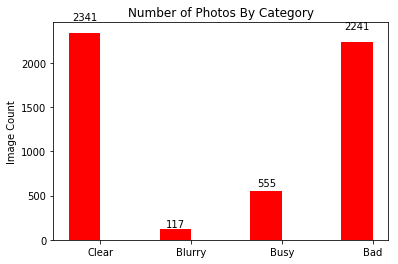

In [3]:
n_clear = len(os.listdir(clear_path))
n_blurry = len(os.listdir(blurry_path))
n_busy = len(os.listdir(busy_path))
n_bad = len(os.listdir(bad_path))

N = 4
n_photos = (n_clear, n_blurry, n_busy, n_bad)

ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind, n_photos, width, color='r')

# add some text for labels, title and axes ticks
ax.set_ylabel('Image Count')
ax.set_title('Number of Photos By Category')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('Clear', 'Blurry', 'Busy', 'Bad'))


def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom')

autolabel(rects1)
plt.show()

##### Early Hypothesis: Edges

Early, when inspecting the data, I had the hypothesis that the good images would have a significant amount of variance in number of detected edges especially after separating images into busy and clear. To test this, I use [Canny Edge Detector](https://en.wikipedia.org/wiki/Canny_edge_detector) from the Python cv2 package. Let's start with a quick example to see why I may have thought this.

###### "good" image
![goodd example Photo](data/example_images/good_edge_image.png)

###### "bad" image
![bad example Photo](data/example_images/bad_edges_image.png)

In [4]:
bad_image_example = 'data/goodbadcombined/busy/diseased_image_525.jpg'
good_image_example = 'data/goodbadcombined/clear_leaves/diseased_image_411.jpg'


print '-------"good" image---------'
transformations.print_avg_edge_pixels(good_image_example)
print ''
print '-------"bad" image---------'
transformations.print_avg_edge_pixels(bad_image_example)


-------"good" image---------
Image shape: 1365 x 768
Average Edge pixels: 13.22 %

-------"bad" image---------
Image shape: 320 x 240
Average Edge pixels: 49.48 %


Obviously, from a single random example, there isn't a whole lot to draw, but my intuition was that edges would exploit some type of differences, so let's explore that a little more. Another reason this initial result may be misleading is becuase of the difference in sizes of images can cause for a huge difference of percentage of pixels and edges only require a thin sliver of pixels. To account for this, I resized all the images to 128x128, the size I use as the input to the CNN later during the forming of the actual model.

In [5]:
def avg_edge_pixels(path, name, size=(128,128)):
    images = utils.load_data(path, setting=0)
    images = transformations.resize_all_images(images, size)
    images = np.ravel(transformations.canny_edge_abs_pixels(images))
    avg_pixels = sum(images)/float(len(images))
    print 'average edge pixels for all', name ,'images:', round(avg_pixels, 2)
    return avg_pixels

# TODO: make this into a visual as well  

avg_edge_pixels(blurry_path, 'Blurry')
print '_____________________________'
avg_edge_pixels(busy_path, 'Busy')
print '_____________________________'
avg_edge_pixels(clear_path, 'Clear')
print '_____________________________'
avg_edge_pixels(bad_path, 'Bad')

loading all files from data/goodbadcombined/blurry/ ...
average edge pixels for all Blurry images: 1.75
_____________________________
loading all files from data/goodbadcombined/busy/ ...
average edge pixels for all Busy images: 1.7
_____________________________
loading all files from data/goodbadcombined/clear_leaves ...
average edge pixels for all Clear images: 1.78
_____________________________
loading all files from data/goodbadcombined/bad_image ...
average edge pixels for all Bad images: 1.72


1.7156372342790875

Now, looking at all of the data, the inverse seems to be true. The clear images seem show the most white pixel values. Even with this difference, this is not good enough to fit a regression to. For thoroughness, I will also include the distribution of image sizes

Blurry size distribution
loading all files from data/goodbadcombined/blurry/ ...


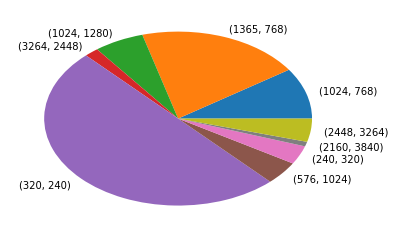

In [25]:
# TODO: make this into a plot for ease of use

print 'Blurry size distribution'
blurry_counts = Counter([v.shape for v in utils.load_data(blurry_path, 0)])
plt.pie([float(v) for v in blurry_counts.values()], labels=[k for k in blurry_counts],
           autopct=None)
plt.show()

Bad size distribution
loading all files from data/goodbadcombined/bad_image ...


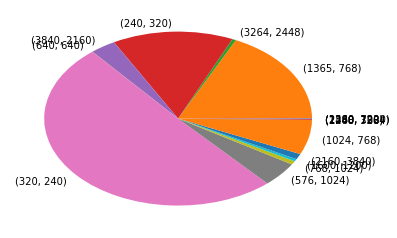

In [23]:
print 'Bad size distribution'
bad_counter = Counter([v.shape for v in utils.load_data(bad_path, 0)])
plt.pie([float(v) for v in bad_counter.values()], labels=[k for k in bad_counter],
           autopct=None)
plt.show()

Busy dimension distribution
loading all files from data/goodbadcombined/busy/ ...


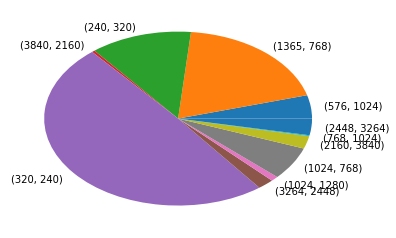

In [24]:
print 'Busy dimension distribution'
busy_counts = Counter([v.shape for v in utils.load_data(busy_path, 0)])
plt.pie([float(v) for v in busy_counts.values()], labels=[k for k in busy_counts],
           autopct=None)
plt.show()

Clear size distribution
loading all files from data/goodbadcombined/clear_leaves ...


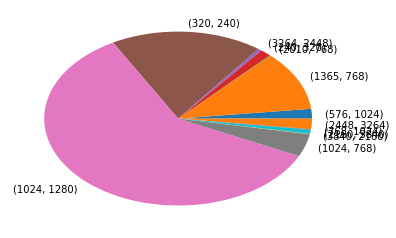

In [26]:
print 'Clear size distribution'
clear_counts = Counter([v.shape for v in utils.load_data(clear_path, 0)])
plt.pie([float(v) for v in clear_counts.values()], labels=[k for k in clear_counts],
           autopct=None)
plt.show()

In [22]:
def plot_history(history):
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    return None

In [9]:
train_generator, validation_generator = ImageGenerator.get_generator()
model = CNN_models.get_multiclass_CNN()

history = model.fit_generator(
        train_generator,
        steps_per_epoch=1000,
        epochs=10,
        validation_data=validation_generator,
        validation_steps=400)

model.save_weights('serialized_objects/small_cnn_0727.h5') 

['acc', 'loss', 'val_acc', 'val_loss']


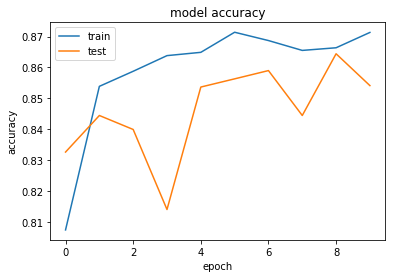

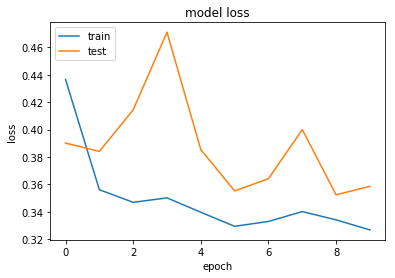

In [4]:
plot_history(history)

In [9]:
# TODO: LOAD CORRECT MODEL AS NOT ALL MODELS OF DIFFERENT DATES ARE THE SAME
model = CNN_models.get_multiclass_CNN()
model.load_weights('serialized_objects/small_cnn_0706.h5')

In [4]:
batch_size = 16
target_size = (150, 150)

output_train = 'serialized_objects/bottleneck_features_train.npy'
output_val = 'serialized_objects/bottleneck_features_validation.npy'
labels = 'serialized_objects/top_model_sizes.p'

train_data = 'data/goodbadcombined/train/'
val_data = 'data/goodbadcombined/validation/'

# TODO: CHANGE DATES OF STORED MODELS TO MAKE SURE NOT TO OVERWRITE ANY PREVIOUSLY TRAINED MODELS
top_model_weights_path = 'serialized_objects/bottleneck_fc_model_0727.h5'

In [5]:
def convert_labels(labels_path, new_labels_path, classes=2):
    train_labels, validation_labels = cPickle.load(open(labels_path, 'rb'))
    new_train = np.zeros((len(train_labels), classes))
    new_valid = np.zeros((len(validation_labels), classes))
    
    for i,v in enumerate(train_labels):
        new_train[i][v] = 1.0
    for i,v in enumerate(validation_labels):
        new_valid[i][v] = 1.0
        
    with open(new_labels_path, 'w') as outfile:
        cPickle.dump((new_train, new_valid), outfile)
        
    return True

new_labels_path = 'serialized_objects/top_model_sizes_multiclass.p'
convert_labels(labels, new_labels_path)

True

In [3]:
topmod_json = 'serialized_objects/top_model_0727.json'
# pretrained.save_bottlebeck_features(target_size, pretrained_json_loc, train_data, val_data, output_train, output_val, labels)
pretrained_model_history = pretrained.train_top_model(topmod_json, top_model_weights_path, output_train, output_val, new_labels_path)

In [26]:
plot_history(pretrained_model_history)

In [6]:
input_shape = (150, 150, 3)
loaded_model = pretrained.load_full_model(topmod_json, top_model_weights_path, input_shape)

loading model json data from file
creating model from json object.
loading model weights...


In [8]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import DirectoryIterator

dir_path = 'data/goodbadcombined/validation/'
target_size = (150,150)
rescale_factor=(1./255)
batch_size = 16

data_gen = ImageDataGenerator(rescale=rescale_factor)
data_iter = DirectoryIterator(dir_path, data_gen, target_size=target_size, batch_size=batch_size, shuffle=False)

Found 1663 images belonging to 2 classes.


In [9]:
# just retrieve a single batch of images and labels to make sure the model loaded correctly
for batch, labels in data_iter:
    break

In [13]:
def translate_predictions(predictions):
#     convert predictions to single value outputs for comprensibility
    return np.array([np.argmax(v) for v in predictions])

In [19]:
raw_predictions = loaded_model.predict(batch)
raw_predictions

array([[  1.00000000e+00,   2.44513660e-21],
       [  9.99820292e-01,   1.79699913e-04],
       [  9.99905109e-01,   9.49177047e-05],
       [  1.00000000e+00,   4.05369058e-30],
       [  1.00000000e+00,   4.42411028e-13],
       [  1.00000000e+00,   2.63587481e-08],
       [  9.99945402e-01,   5.45599214e-05],
       [  1.00000000e+00,   1.77308431e-13],
       [  9.99996662e-01,   3.28903752e-06],
       [  9.99049962e-01,   9.50052694e-04],
       [  1.00000000e+00,   4.37797129e-30],
       [  9.86317098e-01,   1.36828870e-02],
       [  1.30664976e-02,   9.86933470e-01],
       [  1.00000000e+00,   8.27297680e-24],
       [  1.00000000e+00,   1.01324436e-14],
       [  7.03785837e-01,   2.96214193e-01]], dtype=float32)

In [20]:
translate_predictions(raw_predictions)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0])